In [1]:
from __future__ import print_function, division
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pdb
plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images/multi_all_hist'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

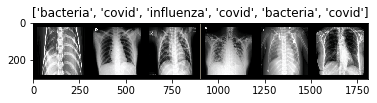

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, label_set, label_class, num_epochs=25):
    since = time.time()
    all_acc = []
    all_loss = []
    all_sens = {key: []  for key in label_set}
    all_spec = {key: []  for key in label_set}
 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    positive_true = dict
    negative_true = dict()
    positive_pred = dict()
    negative_pred = dict()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            positive_true = {key: 0 for key in label_set}
            negative_true = {key: 0 for key in label_set}
            
            positive_pred = {key: 0 for key in label_set}
            negative_pred = {key: 0 for key in label_set}
           
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                for key in positive_true:
                    positive_true[key] += torch.sum(labels.data == key)
                    negative_true[key] += torch.sum(labels.data != key)
                    preds_1 = preds == key
                    true_1 = labels.data == key
                    preds_0 = preds != key
                    true_0 = labels.data != key
                    
                    positive_pred[key] += torch.sum( preds_1 * true_1)
                    negative_pred[key] += torch.sum(preds_0 * true_0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            all_acc.append(epoch_acc)
            all_loss.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            #pdb.set_trace()
            for key in positive_true:
                epoch_sensitive = positive_pred[key].double() / positive_true[key]
                epoch_specificity = negative_pred[key].double()/ negative_true[key]
                all_sens[key].append(epoch_sensitive )
                all_spec[key].append(epoch_specificity )
                
                print('{} {} Sensitivity: {:.4f} specificity: {:.4f}'.format(
            phase,label_class[key], epoch_sensitive, epoch_specificity))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, all_acc, all_sens,all_spec

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
#model_ft = models.resnet18(pretrained=True)
model_ft = models.inception_v3(pretrained=True)
model_ft.aux_logits=False

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft, acc, sens, spec = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs= 20, label_set = [0, 1, 2, 3  ], label_class = class_names )

Epoch 0/19
----------
train Loss: 1.1216 Acc: 0.5012
train bacteria Sensitivity: 0.4522 specificity: 0.8002
train covid Sensitivity: 0.6700 specificity: 0.8627
train influenza Sensitivity: 0.3065 specificity: 0.8109
train normal Sensitivity: 0.5847 specificity: 0.8604
val Loss: 0.8399 Acc: 0.6367
val bacteria Sensitivity: 0.1094 specificity: 0.9704
val covid Sensitivity: 0.7288 specificity: 0.9856
val influenza Sensitivity: 0.8533 specificity: 0.5677
val normal Sensitivity: 0.8116 specificity: 0.9747

Epoch 1/19
----------
train Loss: 0.8696 Acc: 0.6335
train bacteria Sensitivity: 0.5255 specificity: 0.8540
train covid Sensitivity: 0.7800 specificity: 0.9092
train influenza Sensitivity: 0.4484 specificity: 0.8350
train normal Sensitivity: 0.7907 specificity: 0.9123
val Loss: 0.8410 Acc: 0.6404
val bacteria Sensitivity: 0.4062 specificity: 0.8867
val covid Sensitivity: 1.0000 specificity: 0.7452
val influenza Sensitivity: 0.4000 specificity: 0.9219
val normal Sensitivity: 0.8116 specifi

val Loss: 0.6251 Acc: 0.7416
val bacteria Sensitivity: 0.7188 specificity: 0.8374
val covid Sensitivity: 1.0000 specificity: 0.9519
val influenza Sensitivity: 0.4000 specificity: 0.9271
val normal Sensitivity: 0.9130 specificity: 0.9394

Epoch 17/19
----------
train Loss: 0.6148 Acc: 0.7469
train bacteria Sensitivity: 0.6338 specificity: 0.8957
train covid Sensitivity: 0.9133 specificity: 0.9557
train influenza Sensitivity: 0.5903 specificity: 0.8776
train normal Sensitivity: 0.8605 specificity: 0.9329
val Loss: 0.6334 Acc: 0.7416
val bacteria Sensitivity: 0.7500 specificity: 0.8128
val covid Sensitivity: 0.9322 specificity: 0.9712
val influenza Sensitivity: 0.5067 specificity: 0.8958
val normal Sensitivity: 0.8261 specificity: 0.9747

Epoch 18/19
----------
train Loss: 0.6658 Acc: 0.7167
train bacteria Sensitivity: 0.5350 specificity: 0.8836
train covid Sensitivity: 0.8867 specificity: 0.9546
train influenza Sensitivity: 0.6065 specificity: 0.8546
train normal Sensitivity: 0.8505 spec

In [8]:
class_names

['bacteria', 'covid', 'influenza', 'normal']